In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline, make_pipeline

plt.rcParams['figure.figsize'] = (12,7)

# pip install ipympl # nodejs maybe?
# jupyter labextension install jupyter-matplotlib

# %matplotlib widget 

In [21]:
df = pd.read_csv('../others/data_aim_speed.csv')
df = df[df["y_axis"]>=0]
display(df.describe())
df.head()

,x_axis,y_axis,x_speed,y_speed
count,144.000000,144.000000,143.000000,1.150000e+02
mean,32.638889,20.013889,81.990414,1.273432e+01
std,33.229570,35.630384,137.440361,5.316787e+01
min,0.000000,0.000000,0.009845,1.000000e-14
25%,10.000000,0.000000,1.607713,3.000321e-01
50%,18.000000,4.000000,11.471057,4.928571e-01
75%,47.000000,14.250000,97.253815,1.432021e+00
max,127.000000,127.000000,557.435721,3.860577e+02


,x_axis,y_axis,x_speed,y_speed
0,0,13,0.009845,0.183703
1,0,14,0.040972,0.839762
2,0,18,0.191212,5.146364
3,0,24,0.379694,14.440056
4,0,31,0.541891,NaN


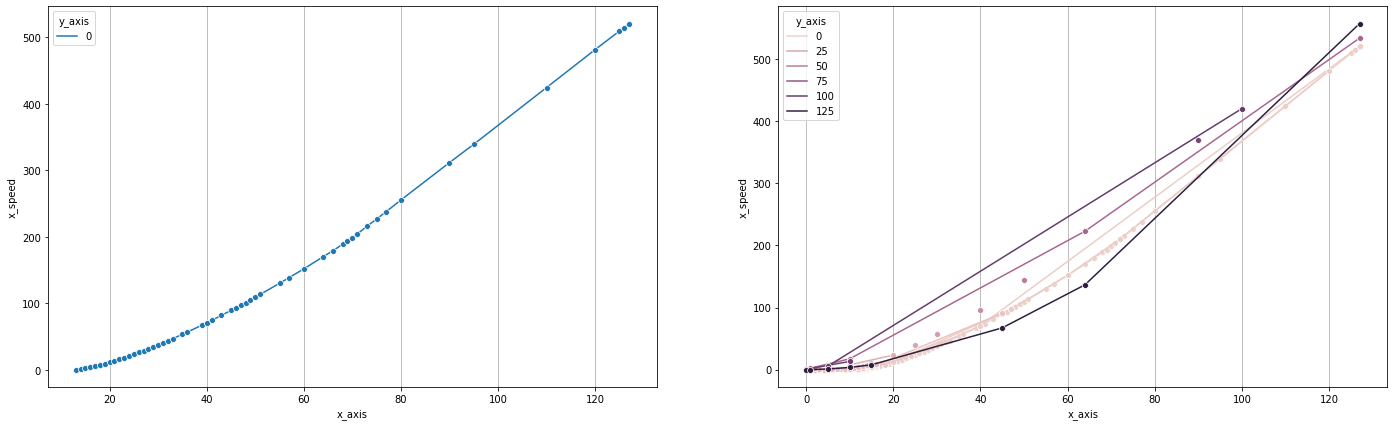

In [22]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 7))
sns.lineplot(data=df[df['y_axis']==0], x='x_axis', y='x_speed', hue='y_axis', marker='o', ax=ax1)
ax1.grid(axis='x')
sns.lineplot(data=df, x='x_axis', y='x_speed', hue='y_axis', marker='o', ax=ax2)
ax2.grid(axis='x')

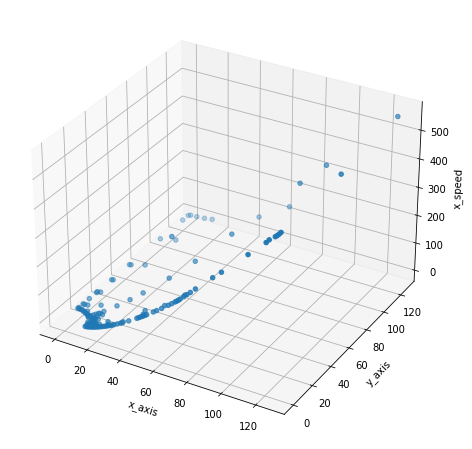

In [6]:
df['r_speed'] = (df['x_speed']**2+df['y_speed']**2)**0.5
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
# ax = Axes3D(fig)
_z_axis = 'x_speed'
ax.scatter(df['x_axis'],df['y_axis'],df[_z_axis]);

ax.set_xlabel("x_axis")
ax.set_ylabel("y_axis")
ax.set_zlabel(_z_axis);
# target = (dfx['x_speed']**2+dfx['y_speed']**2)**0.5

# Analyze the angle

In [5]:
df['ang_out'] = np.arctan(df['y_speed']/df['x_speed'])*180/np.pi
df['y_axis/x_axis'] = (df['y_axis']+1.3)/(df['x_axis']+1.3)
df['y_speed/x_speed'] = df['y_speed']/df['x_speed']
df['tan_ratio'] = df['y_speed/x_speed']/df['y_axis/x_axis']
df['r_axis'] = (df['x_axis']**2 + df['y_axis']**2)**0.5
df

,x_axis,y_axis,x_speed,y_speed,r_speed,ang_out,y_axis/x_axis,y_speed/x_speed,tan_ratio,r_axis
0,0,13,0.009845,1.837033e-01,0.183967,8.693247e+01,11.000000,1.866029e+01,1.696390e+00,13.000000
1,0,14,0.040972,8.397625e-01,0.840761,8.720675e+01,11.769231,2.049597e+01,1.741488e+00,14.000000
2,0,18,0.191212,5.146364e+00,5.149915,8.787217e+01,14.846154,2.691442e+01,1.812888e+00,18.000000
3,0,24,0.379694,1.444006e+01,14.445047,8.849378e+01,19.461538,3.803077e+01,1.954150e+00,24.000000
4,0,31,0.541891,NaN,NaN,NaN,24.846154,NaN,NaN,31.000000
...,...,...,...,...,...,...,...,...,...,...
138,126,0,514.629714,1.771429e-02,514.629715,1.972202e-03,0.010212,3.442142e-05,3.370651e-03,126.000000
139,127,0,520.646572,1.000000e-14,520.646572,1.100474e-15,0.010133,1.920689e-17,1.895572e-15,127.000000
140,127,2,520.794088,1.385725e-01,520.794106,1.524521e-02,0.025721,2.660792e-04,1.034484e-02,127.015747
141,127,64,534.092497,NaN,NaN,NaN,0.508963,NaN,NaN,142.214627


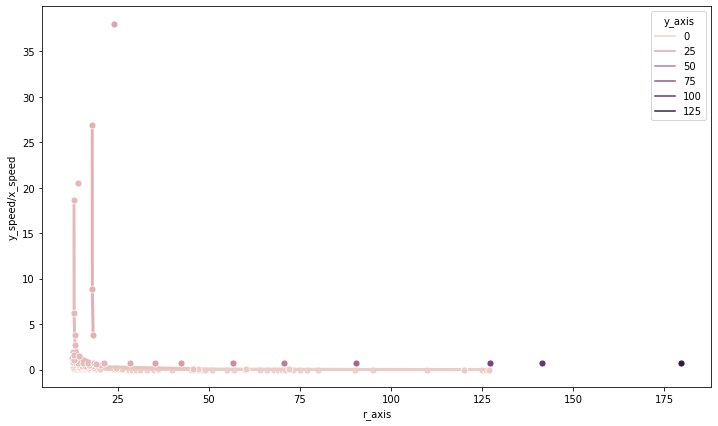

In [6]:
# sns.lineplot(data=df.dropna(), x='y_speed/x_speed', y='tan_ratio', hue='y_axis', marker='o', linewidth=3, markersize=7);
sns.lineplot(data=df.dropna(), x='r_axis', y='y_speed/x_speed', hue='y_axis', marker='o', linewidth=3, markersize=7);

In [7]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import cross_val_score, LeaveOneOut, LeavePOut
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline


df2 = df.dropna()
X = df2[['x_axis','y_axis','x_speed']].copy()
X['y_axis/x_axis'] = (X['y_axis']+0.5)/(X['x_axis']+0.5)
y = df2['y_speed/x_speed']
reg1 = Pipeline([('scaler', StandardScaler()),
                 ('polyfeats', PolynomialFeatures(4, include_bias=False)),
                 ('reg', BayesianRidge())])

methods = [('reg1', reg1)]

R = {}
for name, reg in methods:
    R[name] = -cross_val_score(reg, X, y,
                               scoring='neg_mean_absolute_error', cv=LeavePOut(2), n_jobs=6)
    # reg.fit(D[['x_speed']], D['y_speed'], reg__sample_weight=1/(D['x_speed']+100))
    # D['y_speed_%s' % name] = reg.predict(D[['x_speed']])

display(pd.DataFrame(R).agg(['mean', 'std', 'median', 'max']))
display(pd.DataFrame(R).quantile(0.95))

,reg1
mean,0.209105
std,0.920811
median,0.001152
max,6.462071


reg1    0.632806
Name: 0.95, dtype: float64

# Analyze x_speed vs y_speed

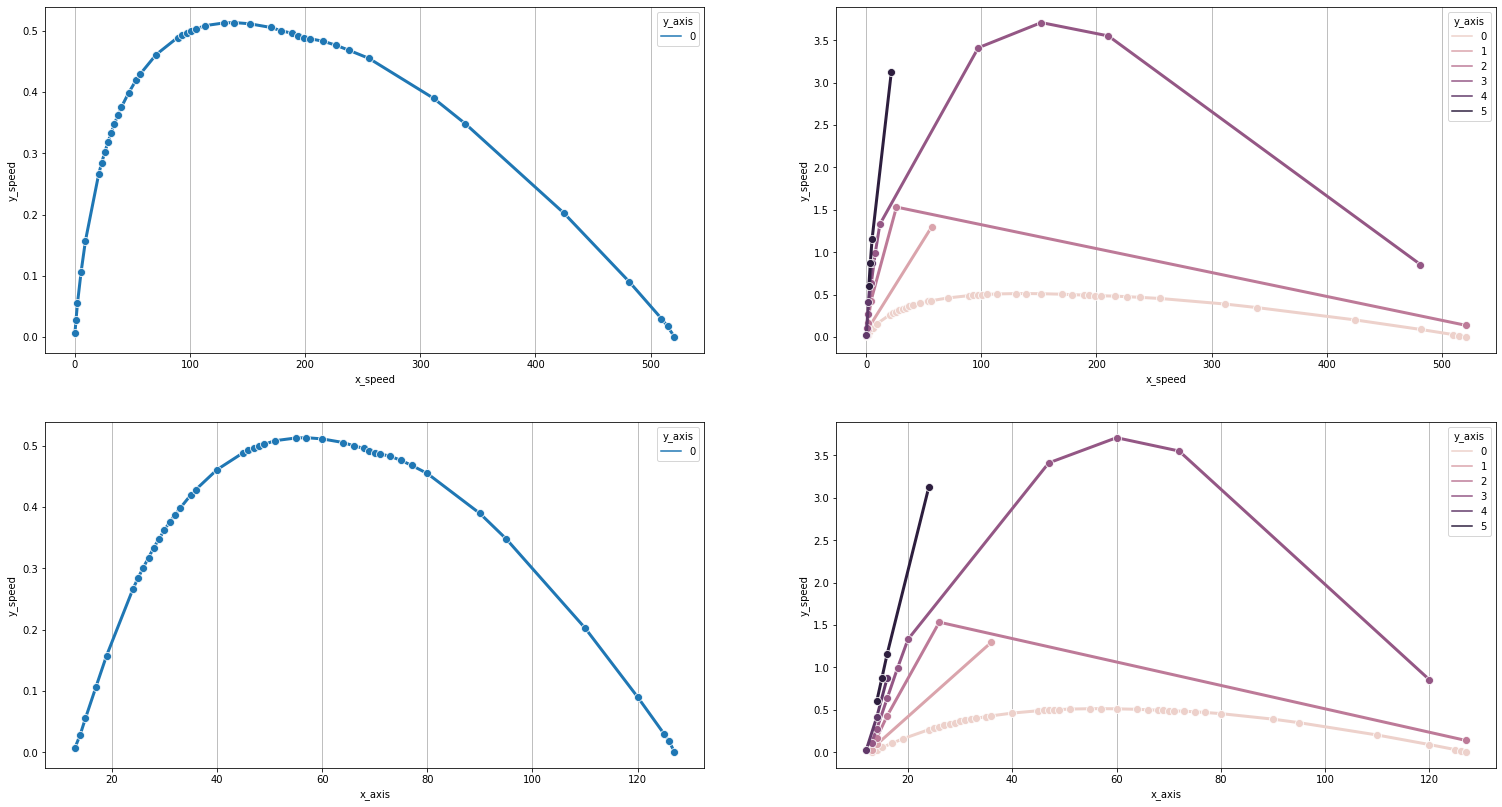

In [8]:
_,axes = plt.subplots(2,2,figsize=(26,14))
sns.lineplot(data=df[df['y_axis']==0], x='x_speed',y='y_speed',hue='y_axis',marker='o', linewidth=3, markersize=8, ax=axes[0,0]);
sns.lineplot(data=df[df['y_axis']<=5], x='x_speed',y='y_speed',hue='y_axis',marker='o', linewidth=3, markersize=8, ax=axes[0,1]);
sns.lineplot(data=df[df['y_axis']==0], x='x_axis',y='y_speed',hue='y_axis',marker='o', linewidth=3, markersize=8, ax=axes[1,0]);
sns.lineplot(data=df[df['y_axis']<=5], x='x_axis',y='y_speed',hue='y_axis',marker='o', linewidth=3, markersize=8, ax=axes[1,1]);
for ax in axes.flatten():
    ax.grid(axis='x');

In [9]:
df2=df.copy()
df2['big_x_axis'] = df2['x_axis']>=55
df2.groupby(['y_axis','big_x_axis']).count()

x_axis  x_speed  y_speed  r_speed  ang_out  y_axis/x_axis  \
y_axis big_x_axis                                                              
0      False           31       30       24       23       23             31   
       True            20       20       20       20       20             20   
1      False            3        3        3        3        3              3   
2      False            3        3        3        3        3              3   
       True             1        1        1        1        1              1   
3      False            6        6        6        6        6              6   
       True             3        3        3        3        3              3   
4      False            3        3        3        3        3              3   
5      False            4        4        4        4        4              4   
6      False            3        2        3        2        2              3   
7      False            1        1        1        1        1              1   
8      False            6        6        6        6        6              6   
9      False            1        1        1        1        1              1   
10     False            4        4        4        4        4              4   
11     False            3        3        3        3        3              3   
12     False            4        4        4        4        4              4   
13     False            7        7        7        7        7              7   
14     False            1        1        1        1        1              1   
15     False            1        1        1        1        1              1   
18     False            3        3        3        3        3              3   
20     False            2        2        1        1        1              2   
24     False            1        1        1        1        1              1   
25     False            1        1        1        1        1              1   
30     False            1        1        1        1        1              1   
31     False            1        1        0        0        0              1   
32     False            2        2        0        0        0              2   
40     False            1        1        1        1        1              1   
46     False            2        2        0        0        0              2   
50     False            1        1        1        1        1              1   
64     False            3        3        0        0        0              3   
       True             2        2        1        1        1              2   
90     True             1        1        1        1        1              1   
96     False            2        2        0        0        0              2   
100    False            2        2        0        0        0              2   
       True             1        1        1        1        1              1   
120    False            1        1        0        0        0              1   
126    False            1        1        0        0        0              1   
127    False            5        5        0        0        0              5   
       True             2        2        1        1        1              2   

                   y_speed/x_speed  tan_ratio  r_axis  
y_axis big_x_axis                                      
0      False                    23         23      31  
       True                     20         20      20  
1      False                     3          3       3  
2      False                     3          3       3  
       True                      1          1       1  
3      False                     6          6       6  
       True                      3          3       3  
4      False                     3          3       3  
5      False                     4          4       4  
6      False                     2          2       3  
7      False                     1          1       1  
8      Fal

,reg1,reg2
mean,0.020737,0.008787
std,0.013891,0.007829
median,0.018993,0.008458
max,0.054756,0.032634


reg1    0.049698
reg2    0.023849
Name: 0.95, dtype: float64

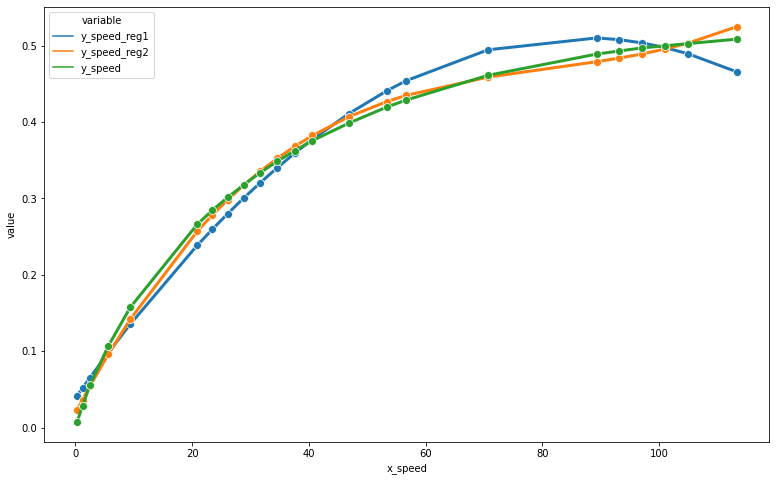

In [10]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import cross_val_score, LeaveOneOut, LeavePOut
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

mask = df['y_axis'] == 0
mask &= df['x_axis'] < 55
D = df[mask].dropna().copy()
X = D[['x_speed']]

reg1 = Pipeline([('scaler', StandardScaler()),
                 ('polyfeats', PolynomialFeatures(2, include_bias=False)),
                 ('reg', BayesianRidge())])
reg2 = Pipeline([('scaler', StandardScaler()),
                 ('polyfeats', PolynomialFeatures(3, include_bias=False)),
                 ('reg', BayesianRidge())])

methods = [
    ('reg1', reg1),
    ('reg2', reg2)
]

R = {}
for name, reg in methods:
    R[name] = -cross_val_score(reg,X , D['y_speed'],
                               scoring='neg_mean_absolute_error', cv=LeavePOut(1), n_jobs=6)
    reg.fit(X, D['y_speed'], reg__sample_weight=1/(D['x_speed']+100))
    D['y_speed_%s' % name] = reg.predict(X)

display(pd.DataFrame(R).agg(['mean', 'std', 'median', 'max']))
display(pd.DataFrame(R).quantile(0.95))
Dmelt = D.melt(id_vars=['x_speed'], value_vars=['y_speed_%s' % name for name, _ in methods]+['y_speed'])
plt.figure(figsize=(13, 8))
sns.lineplot(data=Dmelt, x='x_speed', y='value', hue='variable', marker='o', linewidth=3, markersize=8);

$x_{\text{speed}}$ vs $y_{\text{speed}}$, for $y_\text{axis}=0$:
- For $x_{\text{speed}}\leq 110$, a polynomial of degree 6 fits well, while for $x_{\text{speed}}>110$, a polynomial of degree 4 or 5 fits well to the data
- Ponto de corte parece ser 56.

# Analyze the relation between x_axis and y_axis

In [17]:
dftmp = df[['x_axis','y_axis','x_speed','y_speed']]
dftmp = dftmp.merge(dftmp,
                 left_on=['x_axis', 'y_axis'], right_on=['y_axis', 'x_axis'])
dftmp['x_speed_x/y_speed_y'] = dftmp['x_speed_x']/dftmp['y_speed_y']
dftmp['x_speed_y/y_speed_x'] = dftmp['x_speed_y']/dftmp['y_speed_x']
dftmp

,x_axis_x,y_axis_x,x_speed_x,y_speed_x,x_axis_y,y_axis_y,x_speed_y,y_speed_y,x_speed_x/y_speed_y,x_speed_y/y_speed_x
0,0,13,0.009845,0.183703,13,0,0.265266,0.006697,1.469935,1.443991
1,0,14,0.040972,0.839762,14,0,1.213483,0.028571,1.434022,1.445031
2,0,18,0.191212,5.146364,18,0,7.432897,NaN,NaN,1.444301
3,0,24,0.379694,14.440056,24,0,20.849421,0.265735,1.428845,1.443860
4,0,31,0.541891,NaN,31,0,40.621084,0.375542,1.442957,NaN
5,0,32,0.559790,NaN,32,0,43.702433,0.387187,1.445787,NaN
6,0,46,0.711799,NaN,46,0,93.192347,0.492857,1.444231,NaN
7,0,64,0.719573,NaN,64,0,170.078882,0.505375,1.423839,NaN
8,0,120,0.129548,NaN,120,0,481.536415,0.089966,1.439968,NaN
9,0,126,0.025735,NaN,126,0,514.629714,0.017714,1.452808,NaN


In [18]:
dftmp[['x_speed_x/y_speed_y']].describe()#.agg(['mean','std','median','max','min','argmax','argmin'])

,x_speed_x/y_speed_y
count,40.000000
mean,1.444271
std,0.007809
min,1.423839
25%,1.443408
50%,1.443918
75%,1.444474
max,1.469935


- Remedir (0,13), (13,0), (24,0), (0,24), (4,12), (12,4).
- $f_x(x,y) = 1.444 f_y(y,x)$.